# Evaluation of multi-class drift detection

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from scipy.io import arff

from river import compose
from river import linear_model
from river import metrics
from river import multioutput
from river import preprocessing
from river import tree
from river.naive_bayes import GaussianNB
from tqdm import tqdm
from river.drift import ADWIN
from river.metrics import Accuracy
import matplotlib.pyplot as plt

from river.drift import MLABEL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### MLABEL example usage

In [95]:
import random
from river.drift import MLABEL

stream = []

# Label 1: mostly 0 before drift, mostly 1 after drift
for _ in range(500):
  stream.append([0, random.choices([0, 1], weights=[0.9, 0.1])[0], 1])
for _ in range(500):
  stream.append([0, random.choices([0, 1], weights=[0.1, 0.9])[0], 1])

mlabel = MLABEL()

for i, y in enumerate(stream):
  mlabel.update(y)
  for label, drift in mlabel.drift_detected.items():
    if drift:
      print(f"Drift detected on label {label} at index {i}")

Drift detected on label 1 at index 543


### Sudden drift (simulated data)

Streaming: 100%|██████████| 100000/100000 [09:25<00:00, 176.81it/s]


Overall accuracy using ADWIN: 0.6111
Overall accuracy using MLABEL: 0.638724


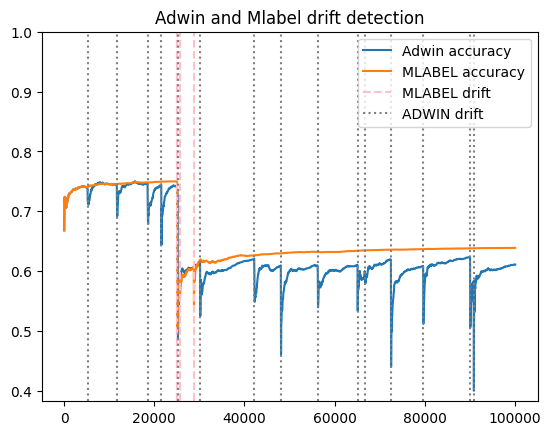

In [87]:
data, meta = arff.loadarff('./data/rt_sudden_balanced.arff')

df = pd.DataFrame(data)
df = df.map(lambda x: x.decode() if isinstance(x, bytes) else x)
target_cols = ['class0', 'class1', 'class2', 'class3', 'class4']
df[target_cols] = df[target_cols].astype(int)
df.head()

# base_clf = compose.Pipeline(
#     preprocessing.StandardScaler(),
#     linear_model.LogisticRegression()
# )

# base_clf = GaussianNB()

base_clf = tree.HoeffdingTreeClassifier()

model = multioutput.ClassifierChain(base_clf)
mlabel_model = multioutput.ClassifierChain(base_clf)

mlabel_detector = MLABEL()
adwin_detector = ADWIN()

full_accuracy = Accuracy()
ml_full_accuracy = Accuracy()

adwin_drift_points = []
mlabel_drift_points = { i: [] for i, label in enumerate(target_cols) }

window = 50
window_accuracies = []
ml_window_accuracies = []

N = len(df)

for i, row in tqdm(df.iterrows(), total=len(df), desc="Streaming"):
    X = row.drop(labels=target_cols).to_dict()
    y = row[target_cols].astype(int).to_dict()

    # Models predict and update
    y_pred = model.predict_one(X)
    model.learn_one(X, y)

    ml_y_pred = mlabel_model.predict_one(X)
    mlabel_model.learn_one(X, y)

    # Metrics update
    for label in target_cols:
        full_accuracy.update(y[label], y_pred.get(label, 0))
        ml_full_accuracy.update(y[label], ml_y_pred.get(label, 0))
    
    if (i + 1) % window == 0:
        window_accuracies.append(full_accuracy.get())
        ml_window_accuracies.append(ml_full_accuracy.get())

    # ADWIN
    y_true_str = ''.join(map(str, row[target_cols].astype(int).values))
    y_pred_str = ''.join(['1' if v else '0' for v in y_pred.values()])
    adwin_detector.update(int(y_true_str == y_pred_str))
    if adwin_detector.drift_detected:
        adwin_drift_points.append(i)
        model = multioutput.ClassifierChain(base_clf)
        full_accuracy = Accuracy()

    # MLABEL
    mlabel_detector.update(row[target_cols].astype(int).values)
    for label, drift in mlabel_detector.drift_detected.items():
        if drift:
            mlabel_drift_points[label].append(i)
            mlabel_model = multioutput.ClassifierChain(base_clf)
            ml_full_accuracy = Accuracy()

# for i, label in enumerate(target_cols):
#     print(f'Drift detected for {label} at indices: {mlabel_drift_points[i]}')

print(f"Overall accuracy using ADWIN: {full_accuracy.get():.4f}")
print(f"Overall accuracy using MLABEL: {ml_full_accuracy.get():4f}")
plt.plot(range(window, N + 1, window), window_accuracies, label='Adwin accuracy')
plt.plot(range(window, N + 1, window), ml_window_accuracies, label='MLABEL accuracy')
for i, label in enumerate(target_cols):
    for drift in mlabel_drift_points[i]:
        plt.axvline(x=drift, color='pink', linestyle='--', label=f'MLABEL drift' if i == 0 else "")

for i, drift in enumerate(adwin_drift_points):
    plt.axvline(x=drift, color='gray', linestyle=':', label='ADWIN drift' if i == 0 else "")
plt.ylim(top=1)
plt.legend(loc='upper right')
plt.title('Adwin and Mlabel drift detection')
plt.show()